# VAE MNIST example
## Pre-requirements
* python 3
* torch
* torchvision
* tqdm
* matplotlib

## Originality
https://github.com/pytorch/examples/tree/master/vae

In [95]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [96]:
batch_size = 128
epochs = 30
num_z = 20

torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch is using', device)

PyTorch is using cuda


In [97]:
# Load MNIST training and test data
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
                                          batch_size=batch_size, shuffle=False)

In [98]:
# Define VAE class, optimizer, loss_function, train and test

import numpy as np

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
        )
        
        self.z_mu = nn.Linear(196, num_z)
        self.z_logvar = nn.Linear(196, num_z)
        
        self.decoder = nn.Sequential(
            nn.Linear(num_z, 196),
            nn.ReLU(),
            nn.Linear(196, 392),
            nn.ReLU(),
            nn.Linear(392, 784)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.z_mu(h), self.z_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return mu + eps*std

    def decode(self, z):
        x_bar = self.decoder(z)
        return torch.sigmoid(x_bar)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        recon_batch = self.decode(z)
        recon_batch = recon_batch.view(*x.shape)
        
        return recon_batch, mu, logvar


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [99]:
from tqdm.notebook import tqdm

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss = train_loss / len(train_loader.dataset)
    
    return train_loss


def reconstruct():
    model.eval()
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)

            n = min(data.shape[0], 8)
            samples = np.array(data[:n].cpu())
            recons = np.array(recon_batch[:n].cpu())
            
            break

    return samples, recons


def test(epoch):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
                
    test_loss /= len(test_loader.dataset)
    
    return test_loss

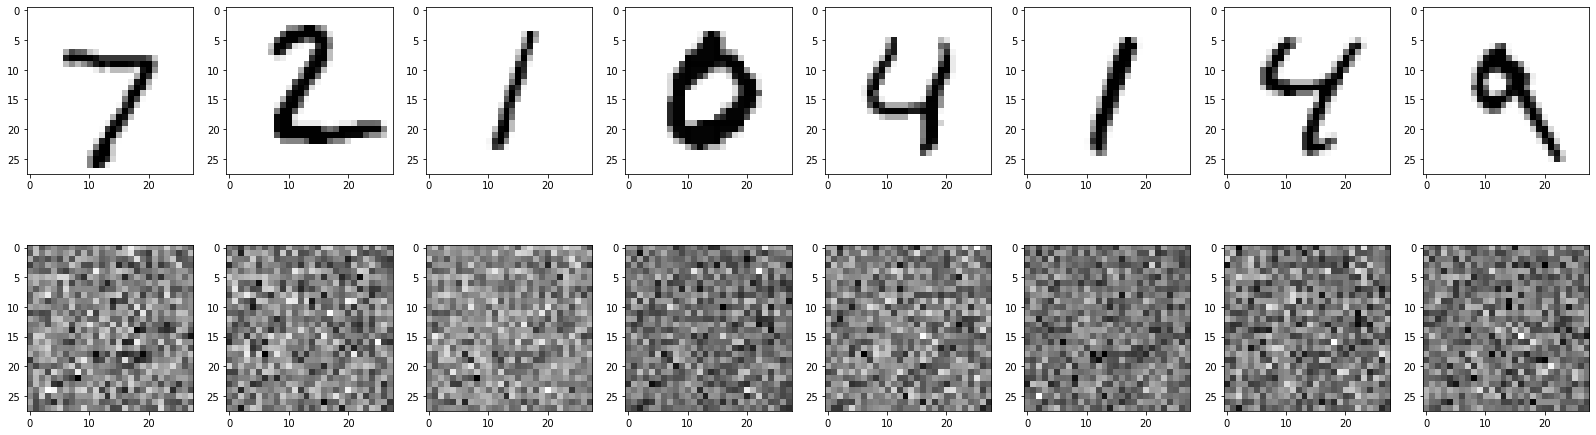

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 / 30: 143.92 in 5.36 secs *


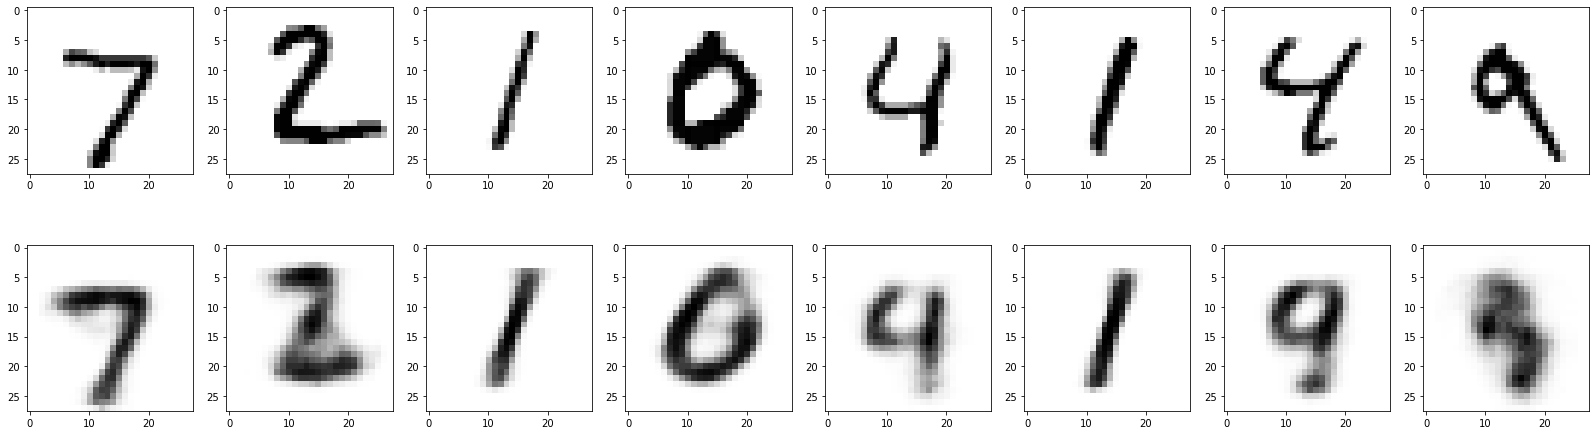

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 / 30: 122.99 in 5.45 secs *


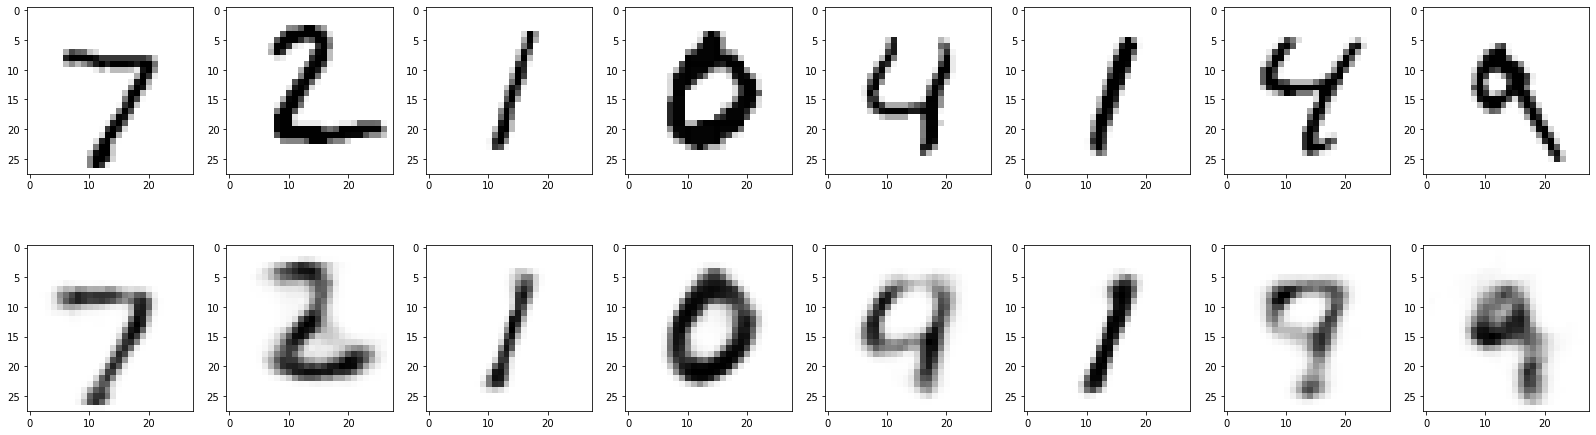

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 / 30: 115.65 in 5.15 secs *


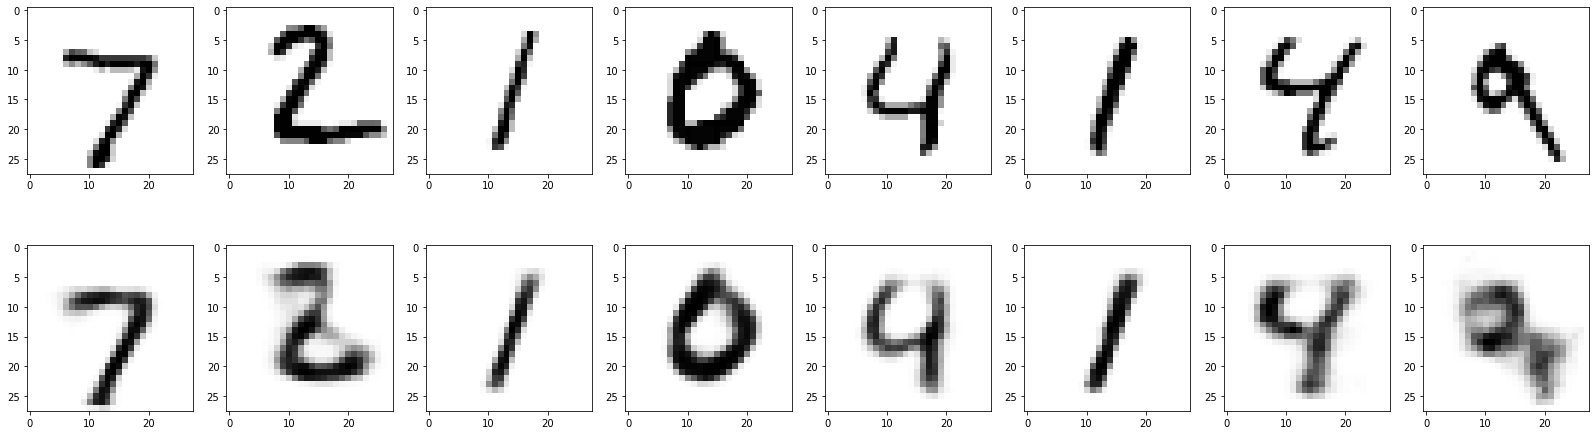

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 / 30: 112.12 in 5.52 secs *


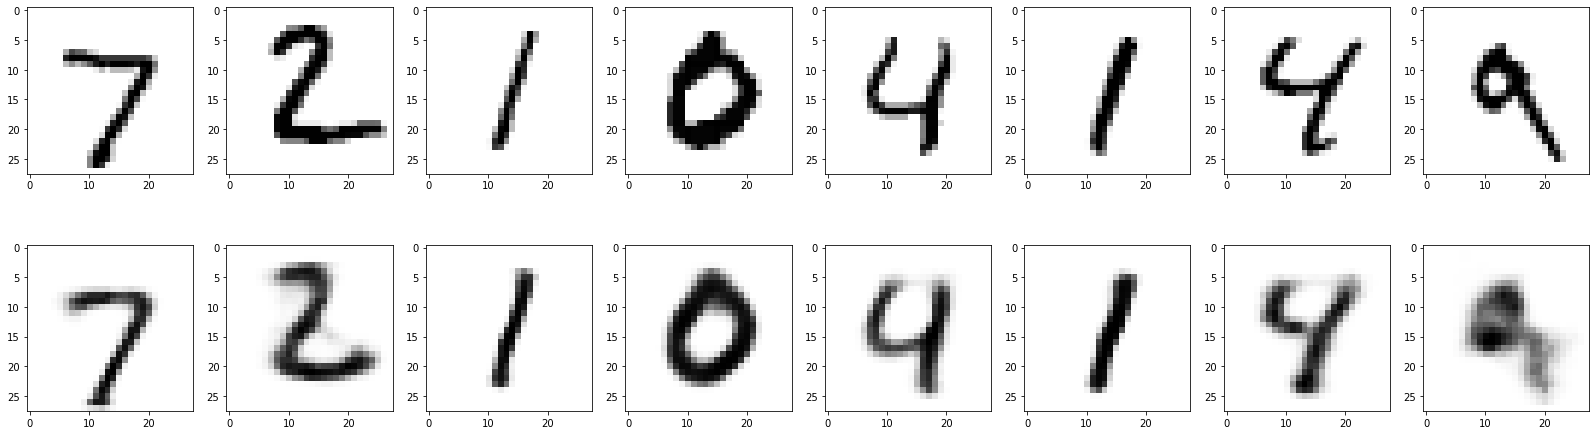

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 / 30: 109.89 in 5.44 secs *


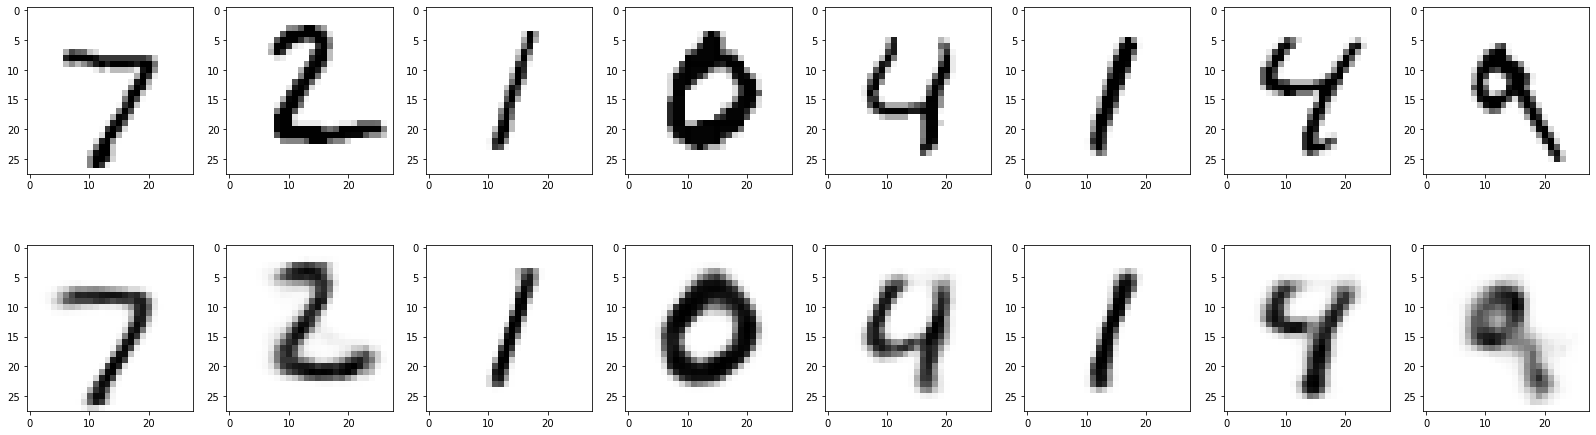

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 / 30: 108.34 in 5.46 secs *


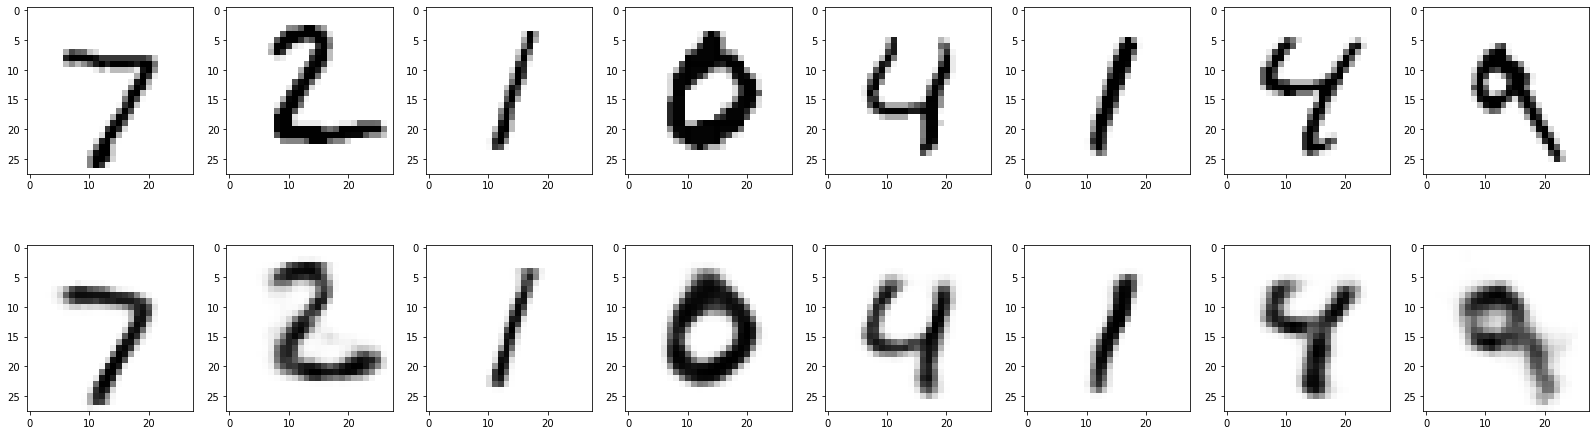

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 / 30: 107.10 in 5.39 secs *


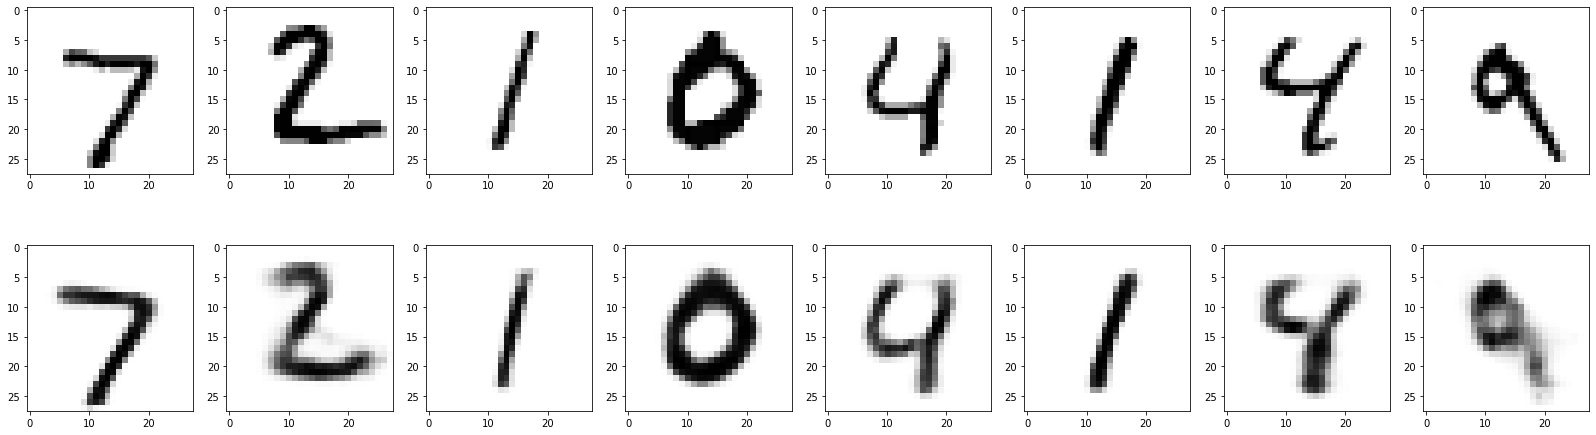

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 / 30: 106.31 in 5.44 secs *


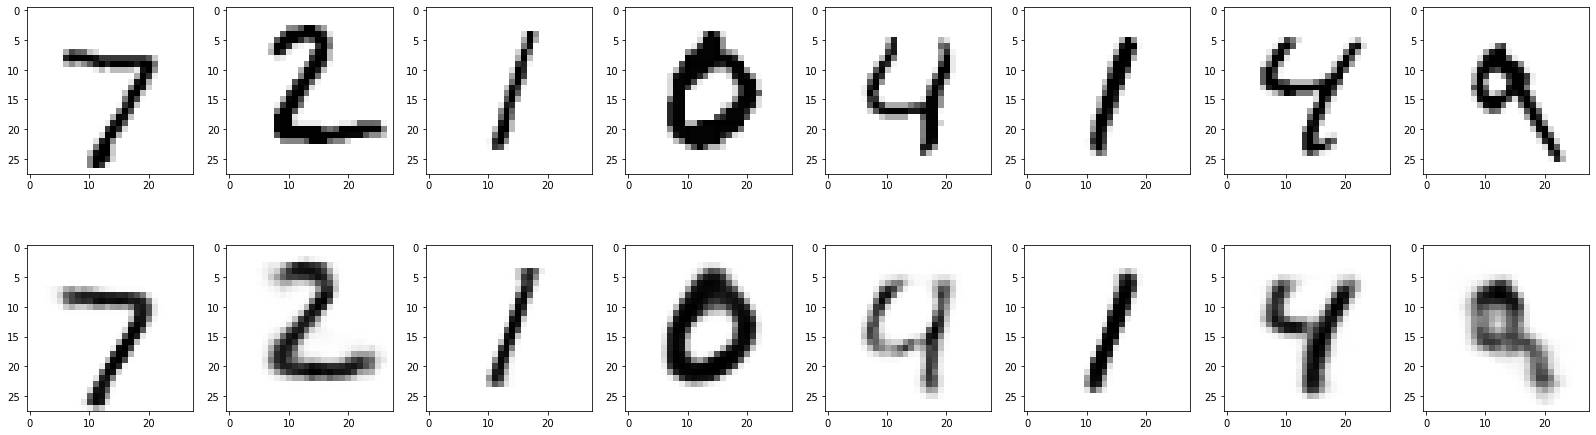

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 / 30: 105.74 in 5.39 secs *


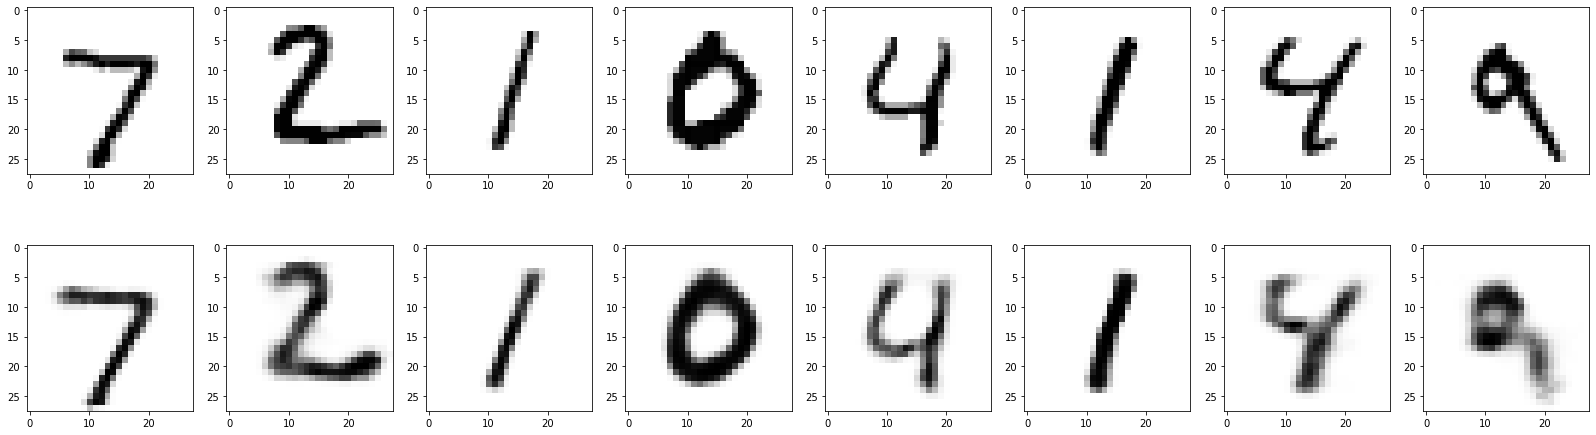

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 / 30: 104.85 in 5.40 secs *


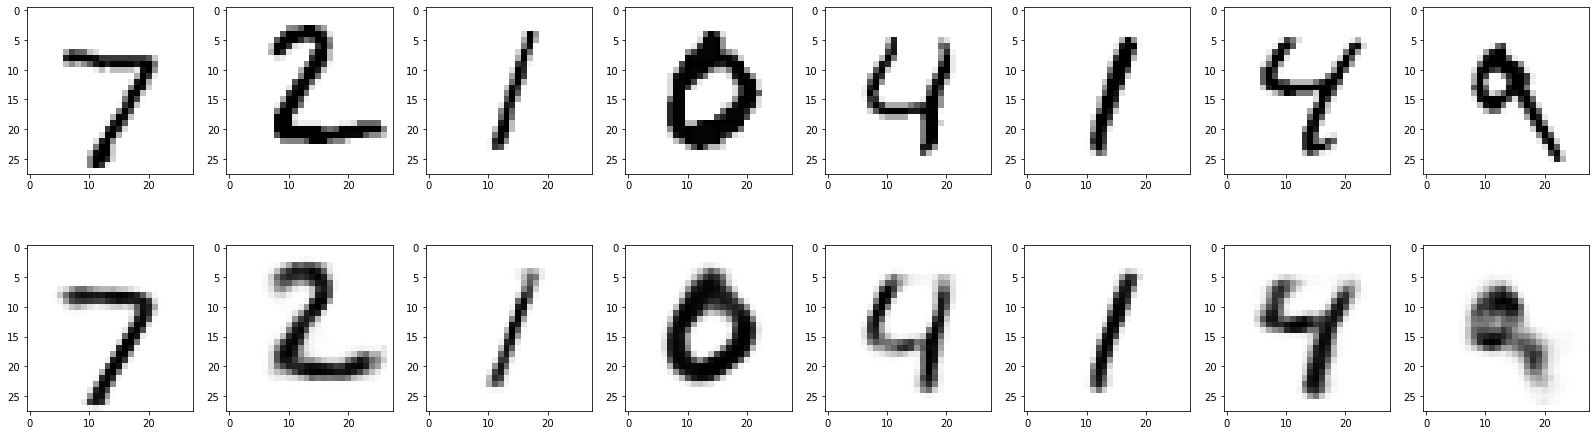

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 / 30: 104.63 in 5.43 secs *


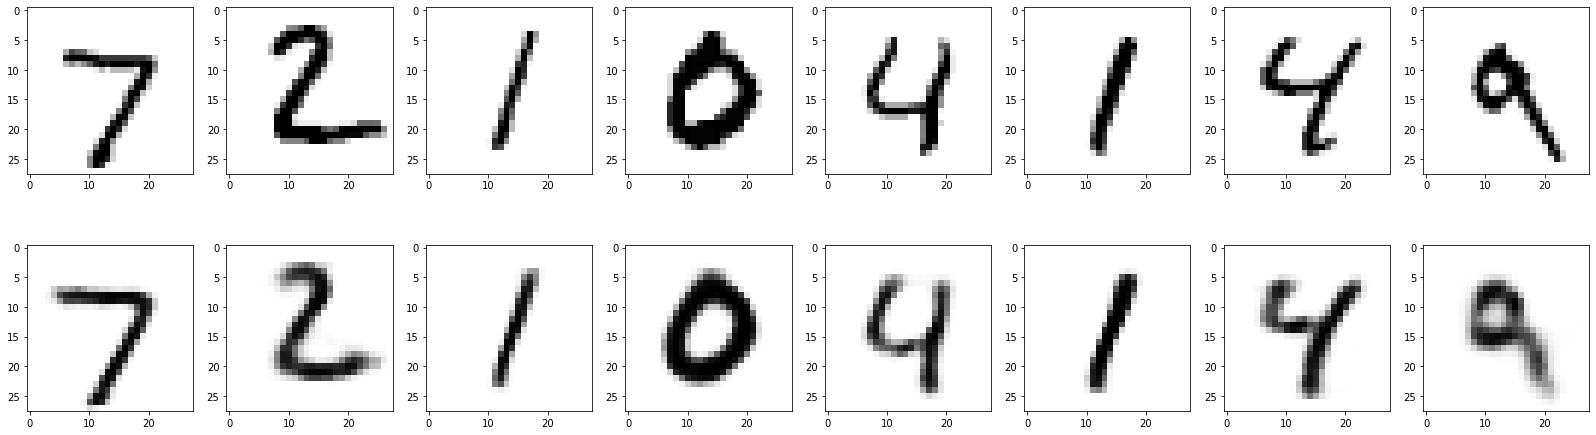

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 / 30: 103.88 in 5.37 secs *


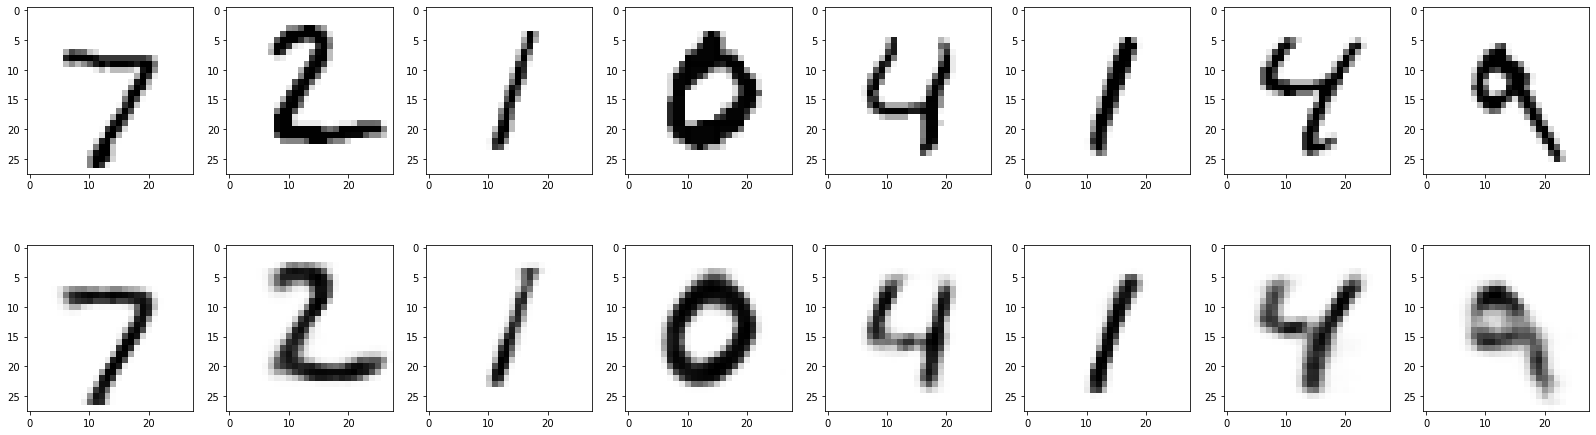

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 / 30: 103.40 in 5.52 secs *


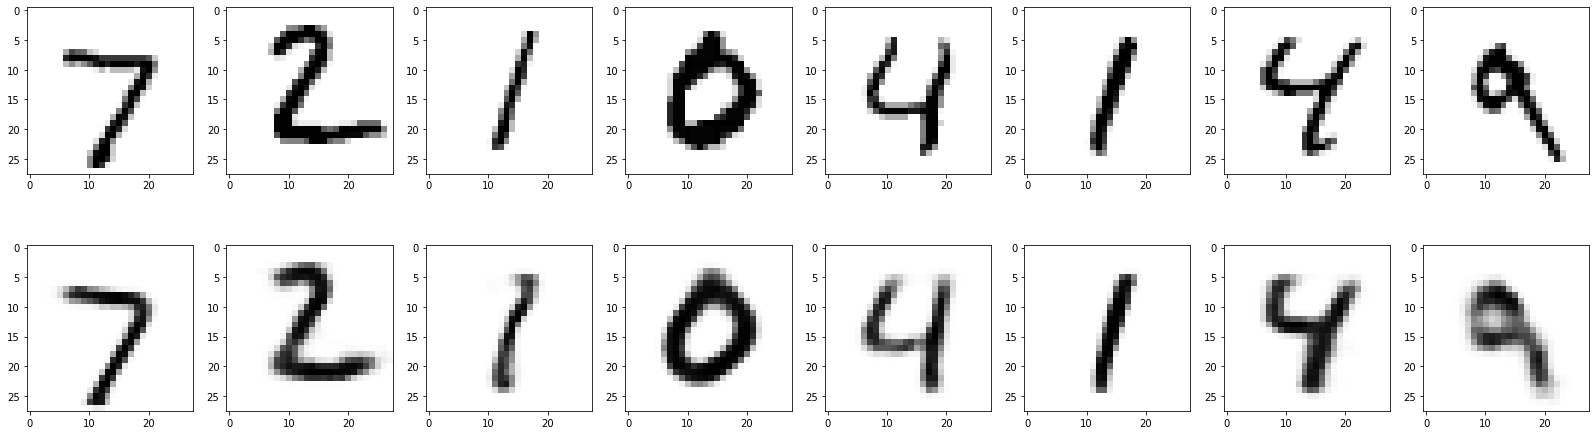

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 / 30: 103.48 in 5.40 secs *


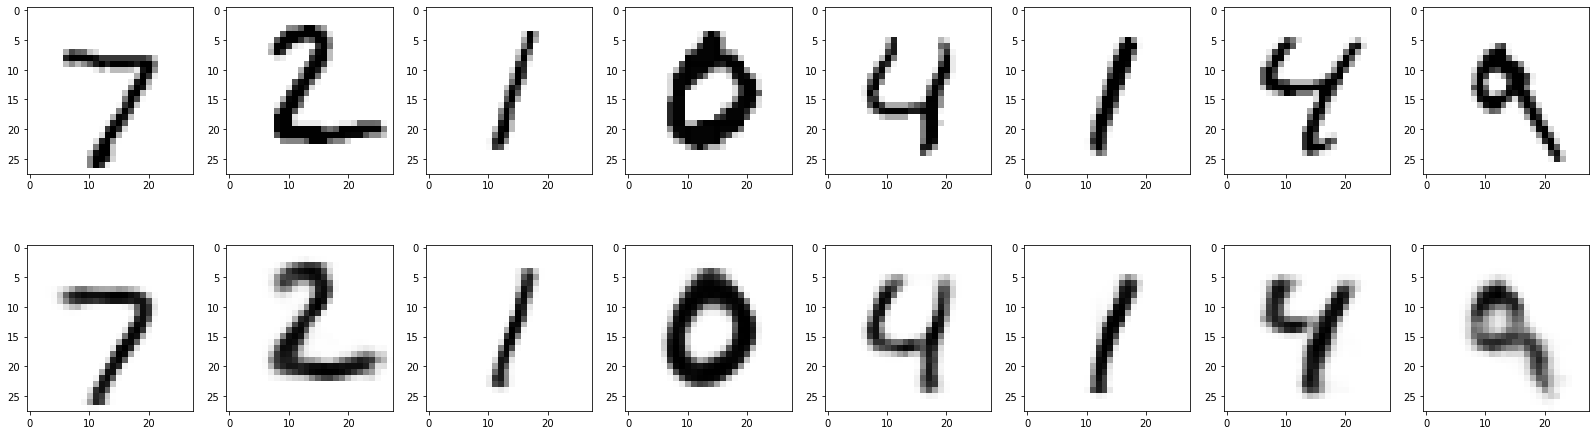

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 / 30: 102.94 in 5.42 secs *


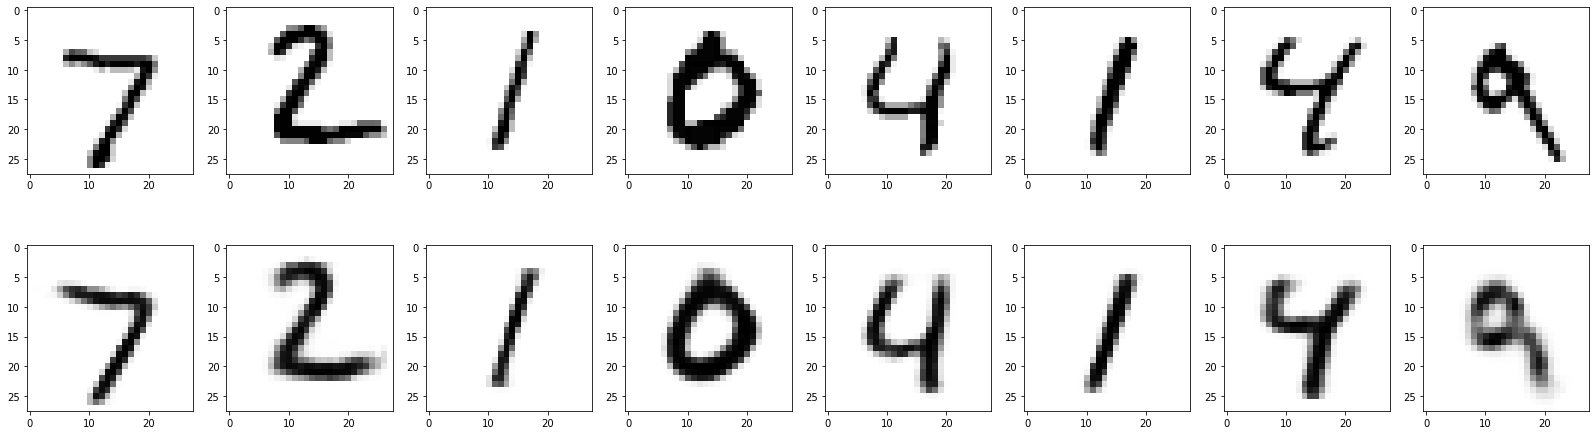

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16 / 30: 103.26 in 5.34 secs *


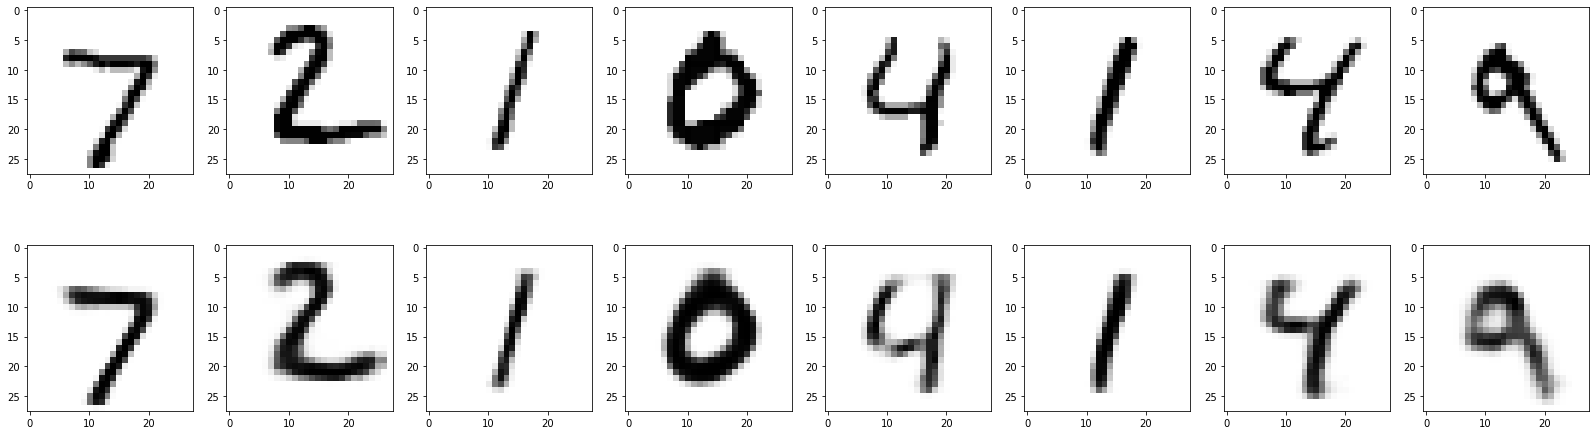

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 / 30: 102.59 in 5.44 secs *


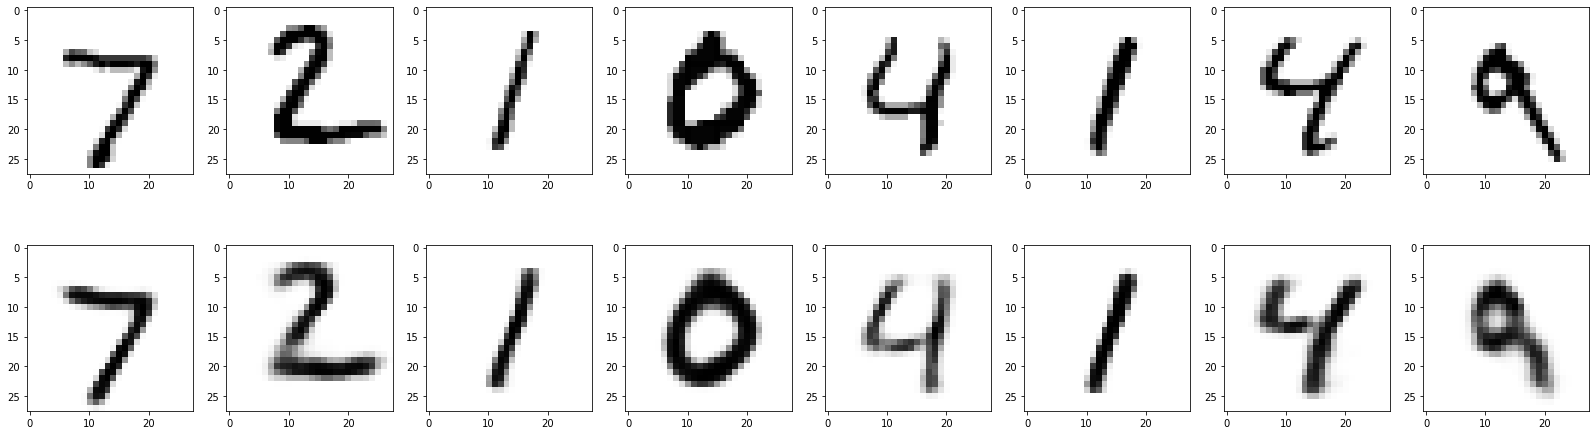

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 / 30: 102.29 in 5.29 secs *


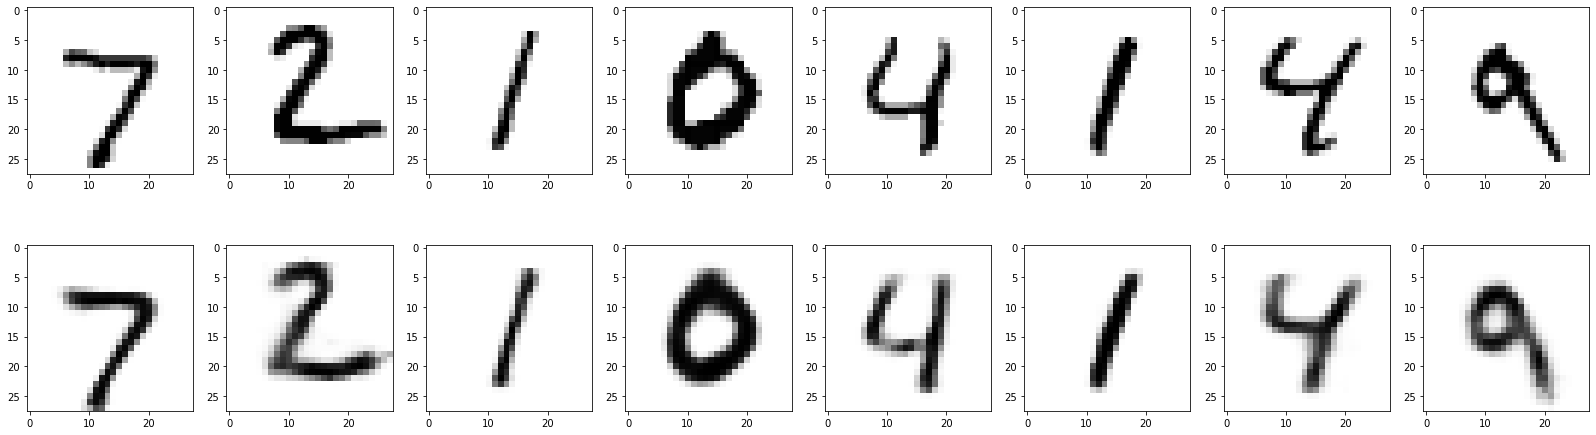

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 / 30: 102.10 in 5.43 secs *


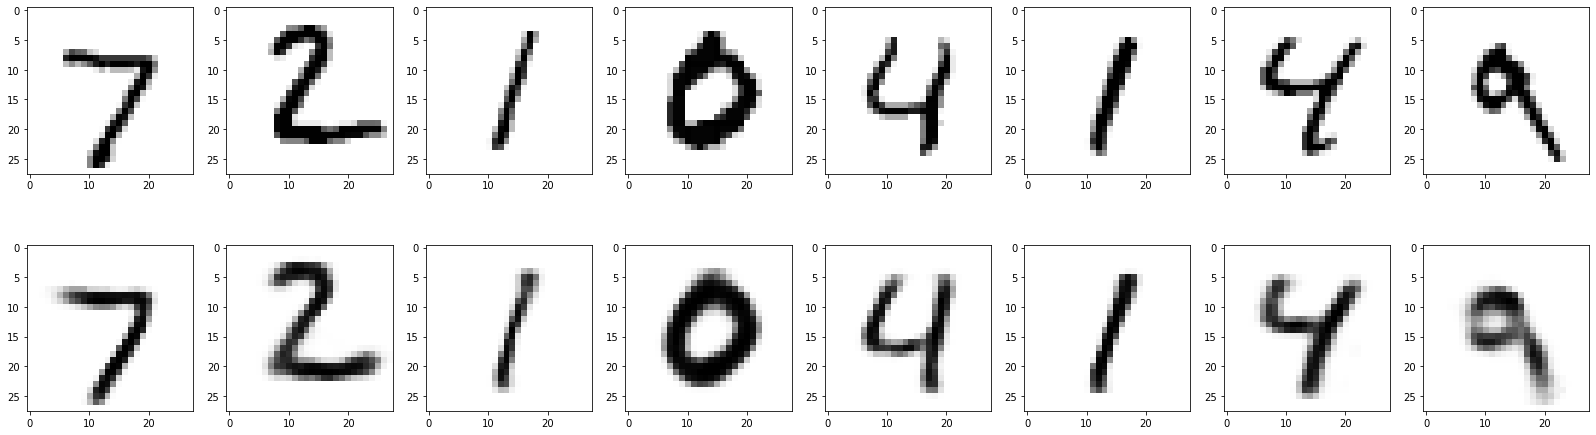

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 / 30: 102.27 in 5.38 secs *


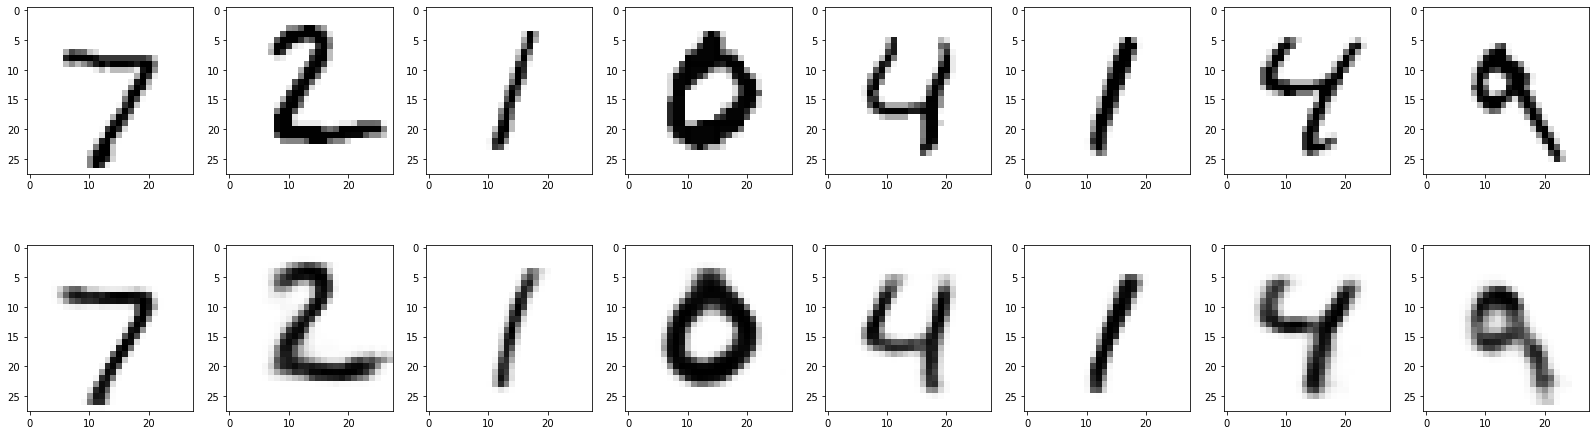

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21 / 30: 101.94 in 5.56 secs *


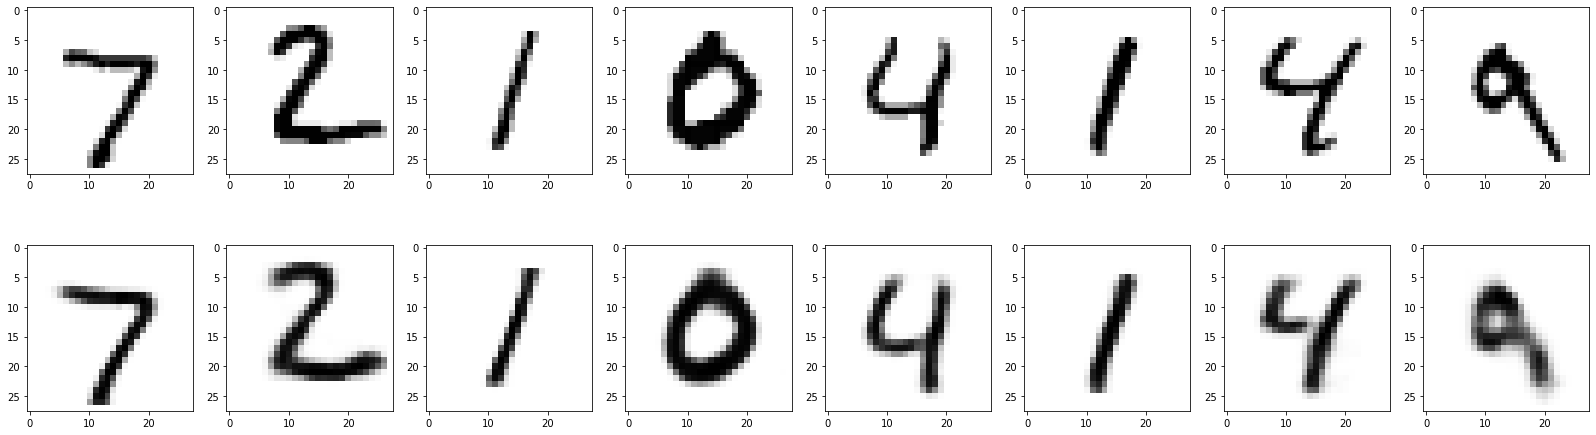

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22 / 30: 101.81 in 5.56 secs *


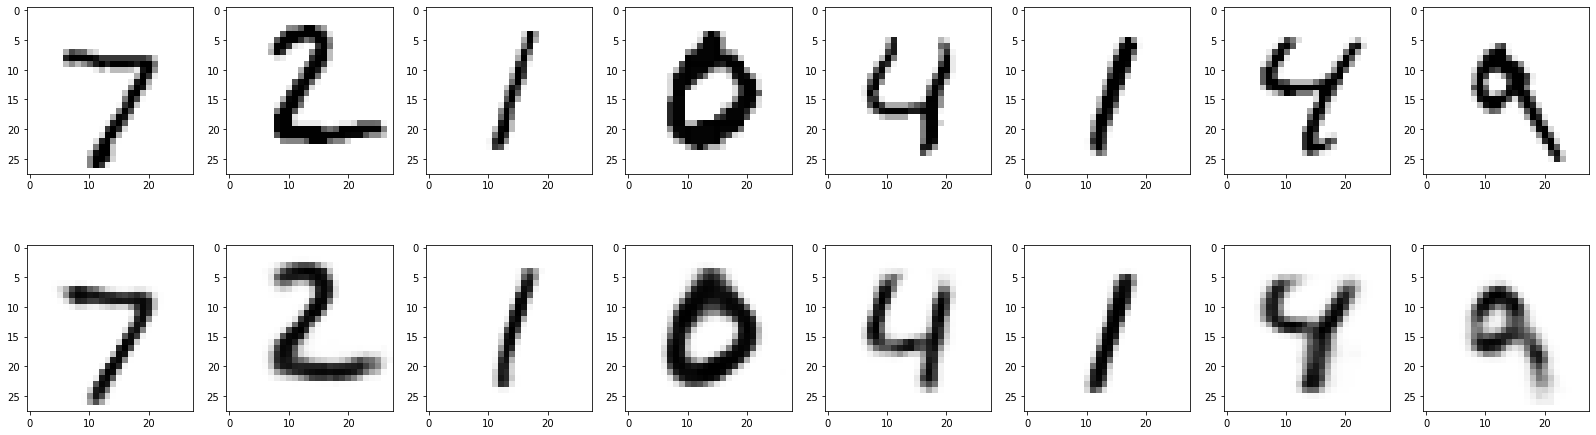

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23 / 30: 101.89 in 5.38 secs *


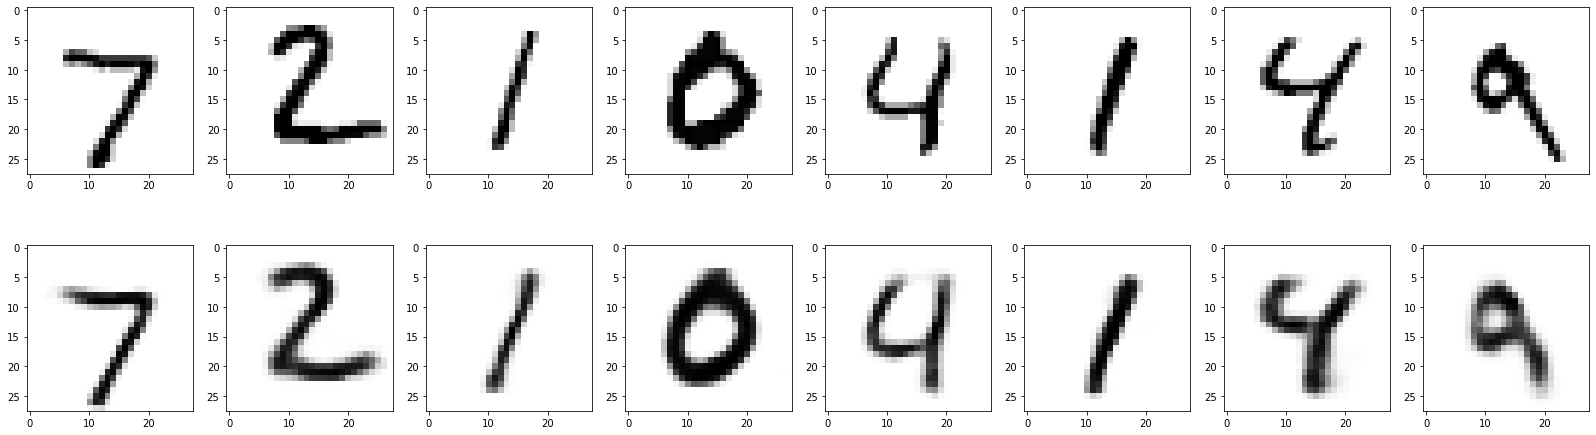

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24 / 30: 101.57 in 5.56 secs *


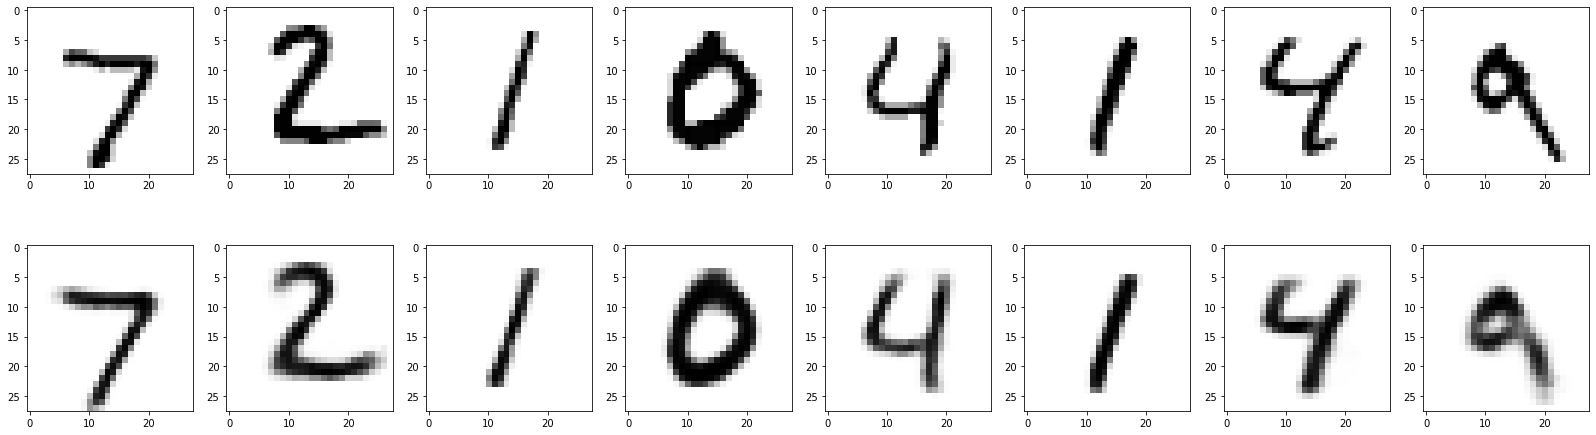

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25 / 30: 101.52 in 5.53 secs *


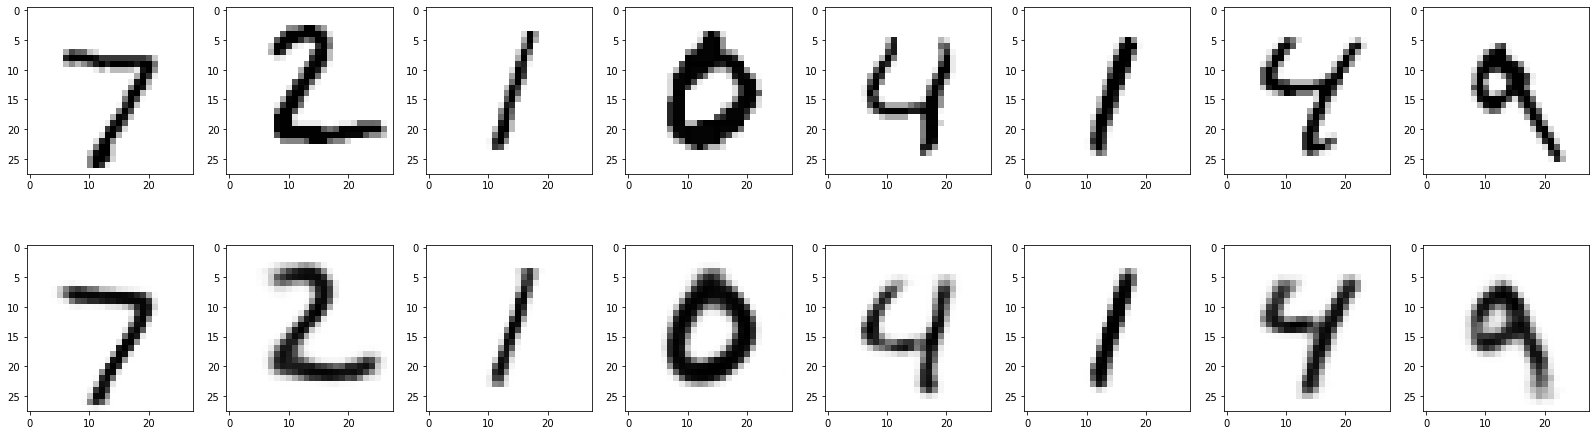

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26 / 30: 101.35 in 5.54 secs *


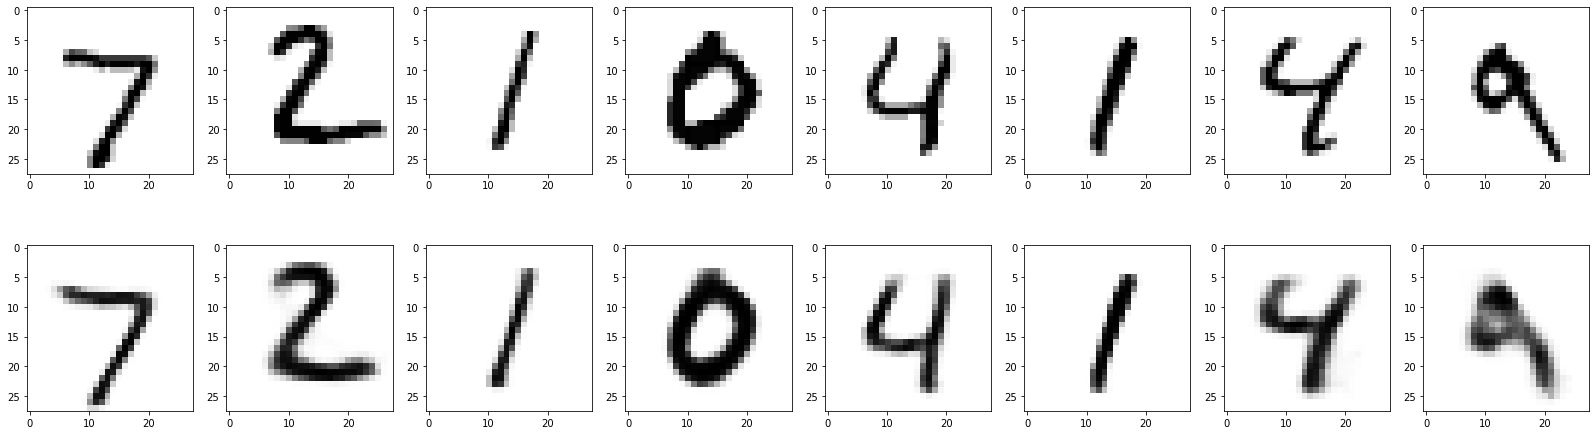

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27 / 30: 101.30 in 5.53 secs *


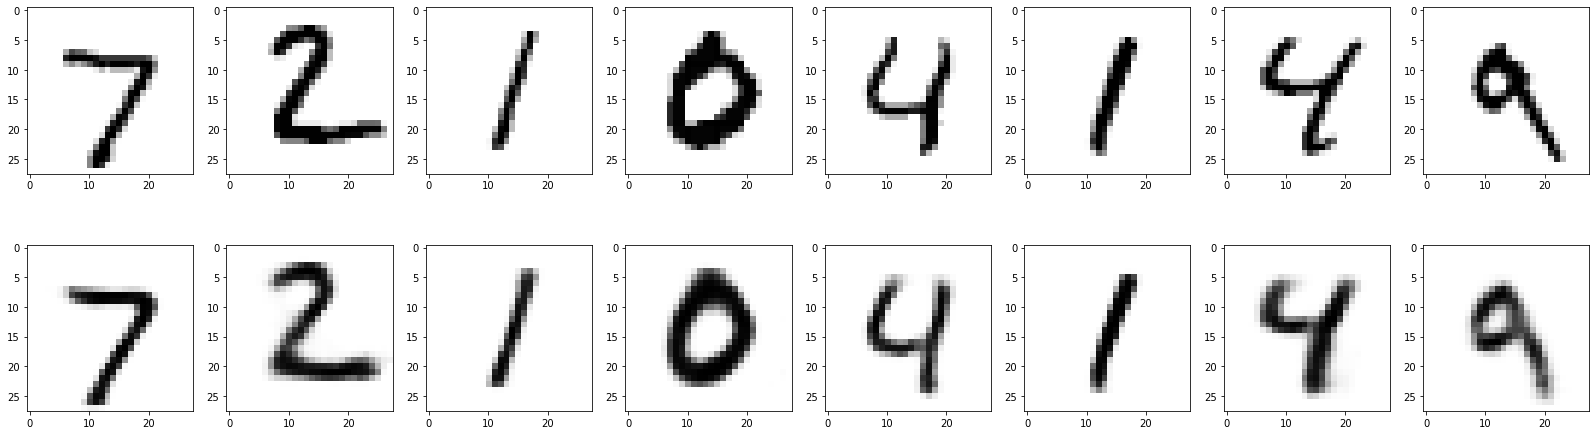

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28 / 30: 101.17 in 5.45 secs *


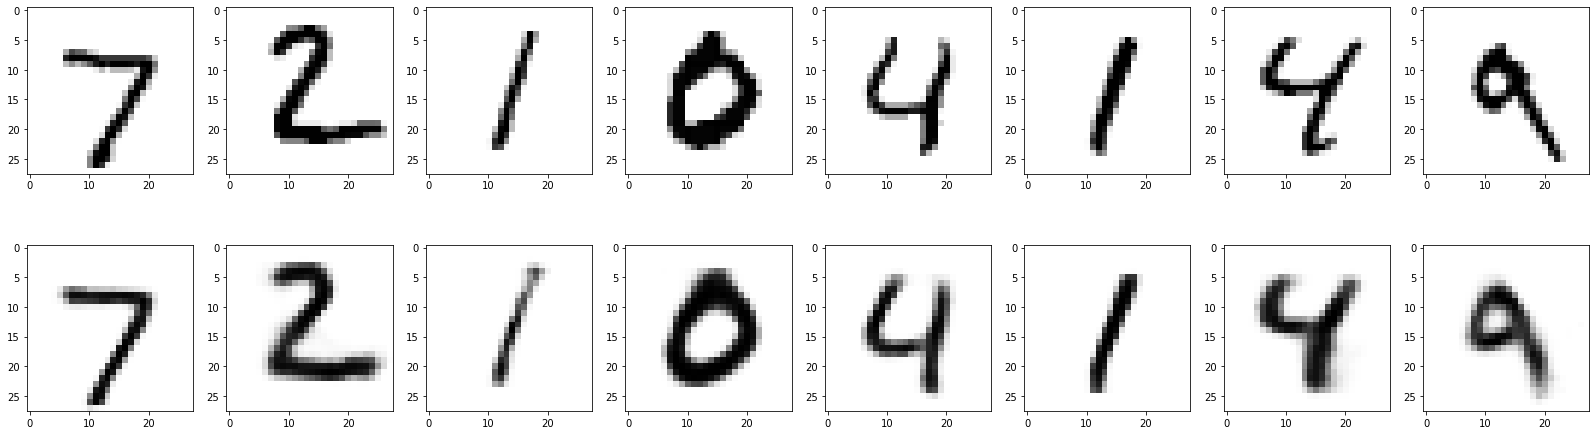

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29 / 30: 101.20 in 5.41 secs *


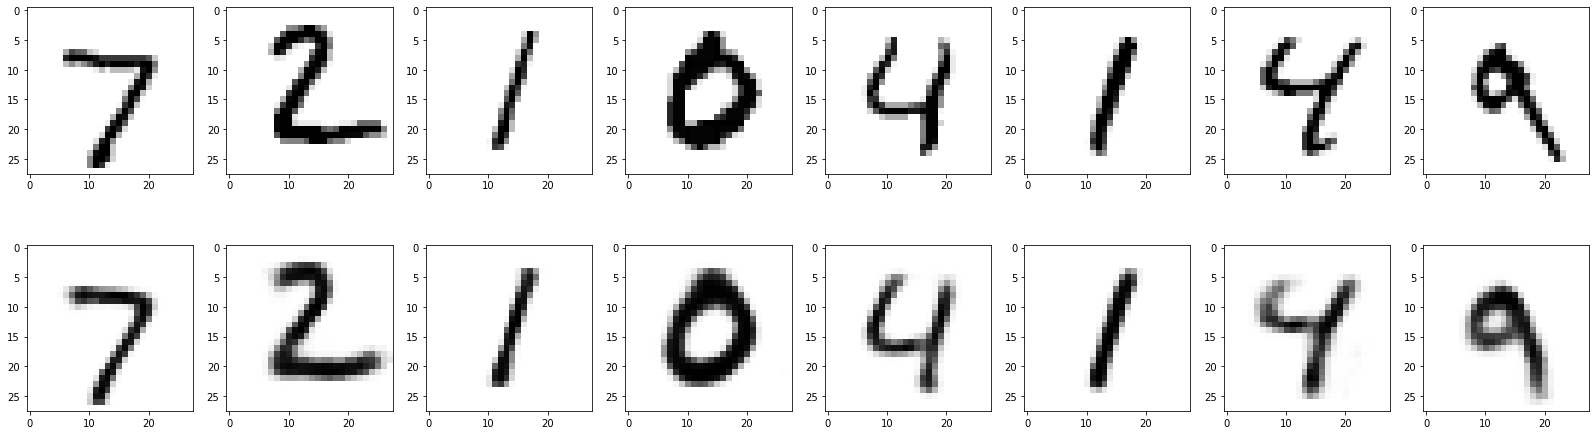

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30 / 30: 100.75 in 5.51 secs *
Average 5.43 secs per epoch consumed
Total 163.04 secs consumed


In [100]:
import matplotlib.pyplot as plt
import time

# Learn
last_loss = torch.finfo(torch.float32).max
total_time = 0

for epoch in range(1, epochs + 1):
    samples, recons = reconstruct()
    
    n = len(samples)
    plt.figure(figsize=(28, 8))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray_r')
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(recons[i].reshape(28, 28), cmap='gray_r')
    plt.show()
    
    start_time = time.time()
    train(epoch)
    end_time = time.time()
    
    dt = end_time - start_time
    total_time += dt
    
    loss = test(epoch)
    
    print(f'Epoch {epoch} / {epochs}: {loss:.2f} in {dt:.2f} secs', '*' if loss < last_loss else '')

print(f'Average {total_time / epochs:.2f} secs per epoch consumed')
print(f'Total {total_time:.2f} secs consumed')
